In [1]:
#based on https://easyfrap.vmnet.upatras.gr/easyfrap_web_manual_appendix.pdf


import pandas as pd
import numpy as np
from os import listdir
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.optimize
import seaborn as sns


In [2]:
sys.path.append('C:/Users/amilas/Desktop/Python-analysis/functions')    

from my_functions import create_fig

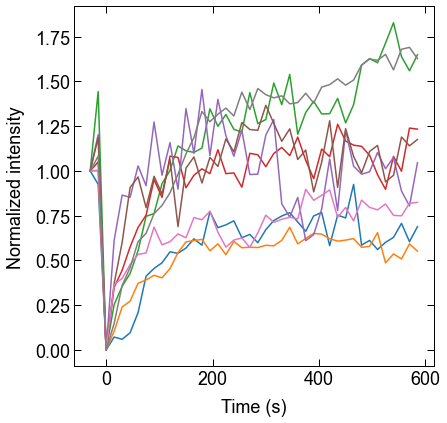

In [3]:
directory = "Par1//"
#directory = "Bazooka//"
dt=15

files = listdir(directory)
fig, ax = create_fig(ylabel="Normalized intensity")
bleach_frame = 2
last_frame = int(600/dt+bleach_frame)
pooled = []

for index, file in enumerate(files[0::3]):
    df = pd.read_csv(f"{directory}/{file}")
    start = df.Frame[0]
    intensity = np.array(df.Mean[0:last_frame])

    df = pd.read_csv(f"{directory}/{files[index*3+1]}")
    background = np.array(df.Mean[start:last_frame+start])

    df = pd.read_csv(f"{directory}/{files[index*3+2]}")
    ooplasm = np.array(df.Mean[0:last_frame])
    time = np.array([dt*i for i in range(len(intensity))])


    #subtract background signal
    intensity_norm = intensity-background
    ooplasm_norm = ooplasm - background

    #double normalization
    #double_norm = (np.mean(ooplasm_norm[0:bleach_frame])/ooplasm_norm)*(intensity_norm/np.mean(intensity_norm[0:bleach_frame]))
    double_norm = (ooplasm_norm[0]/ooplasm_norm)*(intensity_norm/intensity_norm[0])
    
    #full scale normalization
    full_scale_norm = (double_norm - double_norm[bleach_frame]) / (1-double_norm[bleach_frame])

    ax.plot(time- time[bleach_frame], full_scale_norm)

    pooled.append(full_scale_norm)



In [4]:
pooled_df = pd.DataFrame(pooled)
mean_int = pooled_df.mean()
std_int = pooled_df.std()
time = np.array([dt*i for i in range(len(mean_int))])
time = time-time[bleach_frame]



In [5]:
def monoExp(t, b):
    return 1 - (np.exp(-t * b))

R² = 0.9668037094933492
Y = 1 - (1-e^(-[0.01581027] * t))
T_1/2 = [43.84156398]


<ipython-input-5-6add594bdc74>:2: RuntimeWarning: overflow encountered in exp
  return 1 - (np.exp(-t * b))


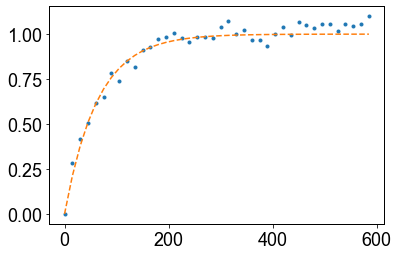

In [6]:
ys = mean_int[bleach_frame:]
xs = np.array([dt*i for i in range(len(ys))])

# perform the fit
params, cv = scipy.optimize.curve_fit(monoExp, xs, ys, maxfev=1000000)
b = params
t_half = np.log(2)/b

# determine quality of the fit
squaredDiffs = np.square(ys - monoExp(xs, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")



# plot the results
plt.plot(xs, ys, '.', label="data")
plt.plot(xs, monoExp(xs, b), '--', label="fitted")


# inspect the parameters
print(f"Y = 1 - (1-e^(-{b} * t))")
print(f"T_1/2 = {t_half}")

Text(-15, 1.3, 'n=8')

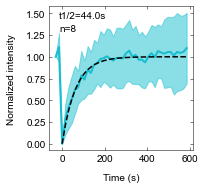

In [40]:
plot_size = "small"
COLOR="black"
fig, ax = create_fig(COLOR=COLOR, plot_size=plot_size, ylabel = "Normalized intensity")

color = sns.color_palette()[-1] 
ax.fill_between(time, mean_int-std_int, mean_int+std_int, alpha=0.5, color=color)

ax.plot(time, mean_int, linewidth=2, color=color)
ax.plot(xs, monoExp(xs, b), '--', label="fitted", color="black")

num=int(pooled_df.shape[0])
title="Par1_FRAP"
ax.text(-15, 1.45, f"t1/2={np.round(t_half[0])}s", size=plt.rcParams['font.size'])

ax.text(-15, 1.3, 'n='+str(num), size=plt.rcParams['font.size'])


In [37]:
fig.savefig(f'{title}_{COLOR}_{plot_size}.pdf', dpi=300, transparent=True, bbox_inches='tight')
fig.savefig(f'{title}_{COLOR}_{plot_size}.png', dpi=300, transparent=True, bbox_inches='tight')